In [145]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
import cv2  
import matplotlib.pyplot as plt  

# define function to load train, test, and validation datasets
def load_dataset(path):
    '''
    Load dataset
    '''
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 7)
    #print(data['filenames'])
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/trainb')
valid_files, valid_targets = load_dataset('data/validb')
test_files, test_targets = load_dataset('data/testb')

# load list of dog names
dog_names = [item[16:-1] for item in sorted(glob("data/trainb/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))



There are 6 total dog categories.
There are 417 total dog images.

There are 326 training dog images.
There are 49 validation dog images.
There are 42 test dog images.


In [146]:
from keras.applications.resnet50 import ResNet50
from keras.models import Model
import keras

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3))
output = restnet.layers[-1].output
output = keras.layers.Flatten()(output)
restnet = Model(restnet.input, output=output)
for layer in restnet.layers:
    layer.trainable = False
#restnet.summary()

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  


In [147]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(restnet)

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['accuracy'])
#model.summary()

In [148]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [149]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(valid_files).astype('float32')/255


100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 203.03it/s]


In [31]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.hdf5', 
                               verbose=1, save_best_only=True)

In [32]:
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=5, batch_size=20, verbose=1, callbacks=[checkpointer])

Train on 326 samples, validate on 49 samples
Epoch 1/5
326/326 [==============================] - 41s 126ms/step - loss: 0.4402 - accuracy: 0.8278 - val_loss: 0.5516 - val_accuracy: 0.7405

Epoch 00001: val_loss improved from inf to 0.55162, saving model to saved_models/weights.hdf5
Epoch 2/5
326/326 [==============================] - 39s 119ms/step - loss: 0.1531 - accuracy: 0.9430 - val_loss: 0.5163 - val_accuracy: 0.7843

Epoch 00002: val_loss improved from 0.55162 to 0.51635, saving model to saved_models/weights.hdf5
Epoch 3/5
326/326 [==============================] - 39s 119ms/step - loss: 0.0791 - accuracy: 0.9750 - val_loss: 0.4961 - val_accuracy: 0.8047

Epoch 00003: val_loss improved from 0.51635 to 0.49612, saving model to saved_models/weights.hdf5
Epoch 4/5
326/326 [==============================] - 39s 119ms/step - loss: 0.0566 - accuracy: 0.9838 - val_loss: 0.4739 - val_accuracy: 0.7872

Epoch 00004: val_loss improved from 0.49612 to 0.47386, saving model to saved_models/

In [150]:
model.load_weights('saved_models/weights.hdf5')

In [152]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

ResNet50_model = ResNet50(weights='imagenet')

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))


def dog_breed(img_path):
    predicted_vector = model.predict(path_to_tensor(img_path)) #shape error occurs here
    #return dog breed that is predicted by the model
    #print(predicted_vector)
    fir = dog_names[np.argmax(predicted_vector)]
    fir_per = np.max(predicted_vector) * 100
    predicted_vector = np.delete(predicted_vector,np.argmax(predicted_vector))   
    
    sec = dog_names[np.argmax(predicted_vector)]
    sec_per = np.max(predicted_vector) * 100
    return fir,fir_per, sec,sec_per


In [153]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def dog_breed_a(image_pth):
    if dog_detector(image_pth):
        img = cv2.imread(image_pth)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img);
        breed_1,per1,breed_2,per2 = dog_breed(image_pth)
        print('이 강아지는', breed_1,per1, "%",'이거나 ' , breed_2, per2,"%")
    else:
        img = cv2.imread(image_pth)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img);
        print('강아지의 사진이 아닌 것 같습니다.')
        breed_1,per1,breed_2,per2 = dog_breed(image_pth)
        print('만약 강아지라면,', breed_1,per1, "%",'이거나 ' , breed_2, per2,"%")


이 강아지는 siba 82.54233002662659 % 이거나  Alaskan_malamute 23.132309317588806 %


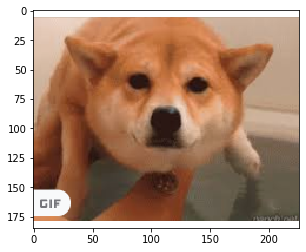

In [154]:
dog_breed_a('images/141.png')